In [62]:
import rasterio as rio
from affine import Affine
from rasterio.crs import CRS
from rasterio.mask import mask
from rasterio.features import shapes, rasterize
import numpy as np

import fiona as fio
import shapely as shp
import geojson

import pandas as pd
import geopandas as gpd

from glob import glob
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from mpl_toolkits import axes_grid1
%matplotlib inline

pd.options.display.max_columns = 105
pd.options.display.max_rows = 200

Helper Functions

In [61]:
#FROM: https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Load and inspect GLODAP data

In [249]:
# In case want to only read partial chunk of the data: 
# https://stackoverflow.com/questions/23853553/python-pandas-how-to-read-only-first-n-rows-of-csv-files-in/23853569
glodap = pd.read_csv("/Users/nathansuberi/Desktop/RW_Data/GLODAPv2 Merged Master File.csv")
print(glodap.shape)
glodap.head(10)

(999448, 101)


,cruise,station,cast,year,month,day,hour,minute,latitude,longitude,bottomdepth,maxsampdepth,bottle,pressure,depth,temperature,theta,salinity,salinityf,salinityqc,sigma0,sigma1,sigma2,sigma3,sigma4,gamma,oxygen,oxygenf,oxygenqc,aou,aouf,nitrate,nitratef,nitrateqc,nitrite,nitritef,silicate,silicatef,silicateqc,phosphate,phosphatef,phosphateqc,tco2,tco2f,tco2qc,talk,talkf,talkqc,phts25p0,phts25p0f,phtsinsitutp,phtsinsitutpf,phtsqc,cfc11,pcfc11,cfc11f,cfc11qc,cfc12,pcfc12,cfc12f,cfc12qc,cfc113,pcfc113,cfc113f,cfc113qc,ccl4,pccl4,ccl4f,ccl4qc,sf6,psf6,sf6f,c13,c13f,c14,c14f,c14err,h3,h3f,h3err,he3,he3f,he3err,he,hef,heerr,neon,neonf,neonerr,o18,o18f,toc,tocf,doc,docf,don,donf,tdn,tdnf,chla,chlaf
0,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,1,8.6,9.0,0.4049,0.404588,33.381,2,1,26.7784,31.4886,36.0930,40.5929,44.9899,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
1,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,2,8.6,9.0,0.5369,0.536580,33.249,2,1,26.6648,31.3723,35.9739,40.4712,44.8658,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
2,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,3,48.9,48.0,2.3604,2.357680,34.806,2,1,27.7870,32.4295,36.9677,41.4034,45.7384,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
3,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,4,48.9,48.0,2.3614,2.358680,34.803,2,1,27.7845,32.4270,36.9652,41.4009,45.7359,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
4,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,5,148.0,146.0,2.4664,2.457870,34.981,2,1,27.9185,32.5568,37.0909,41.5226,45.8538,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
5,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,6,148.0,146.0,2.4724,2.463860,34.986,2,1,27.9220,32.5601,37.0940,41.5255,45.8565,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
6,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,7,148.0,146.0,2.4684,2.459870,34.981,2,1,27.9183,32.5565,37.0906,41.5223,45.8534,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-999

Use groupby to break data apart by year

In [250]:
# Trim GLODAP data for experimentation
glodap_trim = glodap[["year", "latitude", "longitude", "depth", "phts25p0"]]
glodap_trim_grouped = glodap_trim.groupby("year")

# Show number of observations per year
glodap_trim_grouped.count()

,latitude,longitude,depth,phts25p0
year,,,,
1972,4416,4416,4416,4416
1973,5789,5789,5789,5789
1974,4898,4898,4898,4898
1977,1576,1576,1576,1576
1978,2443,2443,2443,2443
1980,4961,4961,4961,4961
1981,12528,12528,12528,12528
1982,4188,4188,4188,4188
1983,9209,9209,9209,9209


In [251]:
# Inspect groupby structure, and accessing first year of data
years = list(glodap_trim_grouped.groups.keys())
print(years)
#print(glodap_trim_grouped.groups)
print(glodap_trim_grouped.get_group(years[0]))

[1972, 1973, 1974, 1977, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
        year  latitude  longitude   depth    phts25p0
255619  1972    44.950    -42.002     1.0 -9999.00000
255620  1972    44.950    -42.002    16.0 -9999.00000
255621  1972    44.950    -42.002    31.0 -9999.00000
255622  1972    44.950    -42.002    48.0 -9999.00000
255623  1972    44.950    -42.002    89.0 -9999.00000
255624  1972    44.950    -42.002   123.0 -9999.00000
255625  1972    44.950    -42.002   157.0 -9999.00000
255626  1972    44.950    -42.002   188.0 -9999.00000
255627  1972    44.950    -42.002   240.0 -9999.00000
255628  1972    44.950    -42.002   286.0 -9999.00000
255629  1972    44.950    -42.002   380.0 -9999.00000
255630  1972    44.950    -42.002   451.0 -9999.00000
255631  1972    44.950    -42.002   500.0 -9999.00000
255632  1

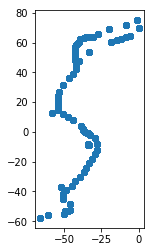

In [252]:
# Store first available year of data
data_1972 = glodap_trim_grouped.get_group(years[0])

# Use latitude and longitude columns to create a GeoDataFrame, add CRS

geometry = [shp.geometry.Point(xy) for xy in zip(data_1972["longitude"], data_1972["latitude"])]
data_1972 = data_1972.drop(['longitude', 'latitude'], axis=1)

crs = {'init': 'epsg:4326'}
geodata_1972 = gpd.GeoDataFrame(data_1972, crs=crs, geometry=geometry)

# Display points
geodata_1972.plot()

In [57]:
# World country boundaries for context
country_bounds = gpd.read_file("/Users/nathansuberi/Downloads/all_countries/all_countries.shp")
country_bounds = country_bounds[["geometry", "name"]]

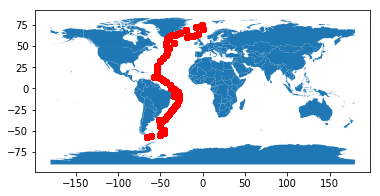

In [253]:
### Q: How to add this into a world map?
# http://geopandas.org/mapping.html
# See bottom for two methods
base = country_bounds.plot()
geodata_1972.plot(ax=base, marker="o", color="red")

Create a base raster to overlay the vector data into

In [145]:
# Create 1 degree raster

def create_transform(row_width,row_rotation, upper_right_x,
                    column_rotation, column_height, upper_right_y):
    
    return(Affine(row_width,row_rotation,upper_right_x,
                  column_rotation, column_height, upper_right_y))

degree1 = create_transform(1,0,-180,0,-1,90)

# Create array of ones size of a global, 1 degree raster
dst_array = np.ones((360, 180), dtype=np.float32)
#dst_array = np.random.randn(360, 180).astype(np.float32)
#print(dst_array)

# Use rasterio to classify this as WGS84 EPSG:4326
world_array = '/Users/nathansuberi/Desktop/RW_Data/world_array.tif'

profile = {
    'driver': 'GTiff', 
    'dtype': np.float32, 
    'nodata': 0, 
    'width': 360, 
    'height': 180, 
    'count': 1, 
    'crs': CRS({'init': 'EPSG:4326'}), 
    'transform':degree1,
    'blockxsize': 128, 
    'blockysize': 128, 
    'tiled': True, 
    'compress': 'lzw', 
    'interleave': 'band'
}
with rio.open(world_array, "w", **profile) as dst:
    dst.write(dst_array, indexes=1)

# Print, observe
with rio.open(world_array, "r") as src:
    world_data = src.read(indexes=1)
    #print(src.profile)
    #print(data)

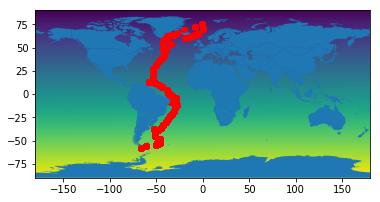

In [254]:
# View raster with vector features over top
# Using plt.gca(): https://gis.stackexchange.com/questions/193653/plot-shapefile-on-top-of-raster-using-plot-and-imshow-from-matplotlib?rq=1
# Setting extent, from Logan's response: https://gis.stackexchange.com/questions/251396/graph-points-in-image-using-matplotlib

# For rainbow coloring:
rows, cols = world_data.shape
for r in range(rows):
    for c in range(cols):
        world_data[r,c] = r*cols+c

# Raster data
# Extent parameter is necessary here for alignment
plt.imshow(world_data, extent = [-180, 180, -90, 90])

# Get current axes
ax = plt.gca()

# Use these axes to plot the vector data
geodata_1972.plot(ax=ax, marker="o", color="red")
country_bounds.plot(ax=ax)

(1, 180, 360)
(180, 360)
[[0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 ..., 
 [-9999.0 -9999.0 -9999.0 ..., -9999.0 -9999.0 -9999.0]
 [-9999.0 -9999.0 -9999.0 ..., -9999.0 -9999.0 -9999.0]
 [-9999.0 -9999.0 -9999.0 ..., -9999.0 -9999.0 -9999.0]]


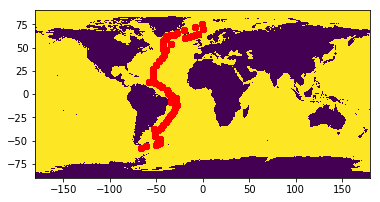

In [255]:
# Mask out all land values

with fio.open("/Users/nathansuberi/Desktop/RW_Data/all_countries/all_countries.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
    
# https://stackoverflow.com/questions/41462999/how-do-i-use-rasterio-python-to-mask-a-raster-using-a-shapefile-to-set-the-rast
with rio.open(world_array, "r") as src:
    out_image, out_transform = mask(src, geoms, crop=False, invert=True)
    out_meta = src.meta.copy()

# Need to squeeze the image so that it becomes only 2 dimensions, 
# instead of having a first "band" dimension
print(out_image.shape)
out_image = np.squeeze(out_image)
print(out_image.shape)
  
out_image[out_image==0] = -9999
out_image[out_image==1] = 0

print(out_image)
plt.imshow(out_image, extent=[-180, 180, -90, 90])

ax = plt.gca()

# Use these axes to plot the vector data
geodata_1972.plot(ax=ax, marker="o", color="red")

In [256]:
# Review geodata_1972 structure
geodata_1972.head()

,year,depth,phts25p0,geometry
255619,1972,1.0,-9999.0,POINT (-42.002 44.95)
255620,1972,16.0,-9999.0,POINT (-42.002 44.95)
255621,1972,31.0,-9999.0,POINT (-42.002 44.95)
255622,1972,48.0,-9999.0,POINT (-42.002 44.95)
255623,1972,89.0,-9999.0,POINT (-42.002 44.95)


| 1.00, 0.00,-180.00|
| 0.00,-1.00, 90.00|
| 0.00, 0.00, 1.00|
     0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

(180, 360)

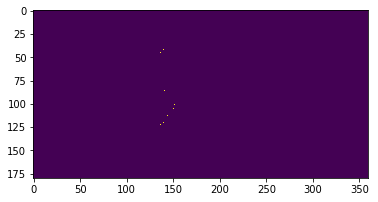

In [263]:
# Overlay GLODAP data with the raster

shapes_to_rasterize = ((geom,value) for geom, value in zip(geodata_1972["geometry"], geodata_1972["phts25p0"]))

print(out_transform)

image = rasterize(
            shapes_to_rasterize,
            out=out_image,
            out_shape=out_image.shape,
            transform=out_transform,
            all_touched=True,
            dtype=np.float32,
            default_value=10,
            fill=10)

# This is working!
print(pd.DataFrame(image[50:100, 100:150]))
image[image==-9999] = 0
plt.imshow(image)
image.shape

In [300]:
# Calculate average value for each raster cell

# Bin data by lat-long squares
# Could create a polygon "raster": https://gis.stackexchange.com/questions/54119/creating-square-grid-polygon-shapefile-with-python
# And then burn into a raster of same extent

# -OR-

# Can fill world_data with unique values to force creation of separate
rows, cols = world_data.shape
for r in range(rows):
    for c in range(cols):
        world_data[r,c] = r*cols+c

# https://stackoverflow.com/questions/37728540/create-a-geodataframe-from-a-geojson-object
# https://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python
world_1degree_grid_vectors, _ = zip(*shapes(world_data, transform=degree1))
features = [geojson.Feature(geometry=feature) for feature in world_1degree_grid_vectors]        
#print(features)

crs = {'init': 'epsg:4326'}
vector_raster_grid = gpd.GeoDataFrame.from_features(features, crs=crs)
# Ensure that length of the index makes sense, 1 index per every raster cell
assert(len(vector_raster_grid.index)==(360*180))

observations_per_grid = gpd.sjoin(vector_raster_grid, geodata_1972, how="left", op="intersects")

In [307]:
## View the data sets that contributed to the observations_per_grid gdf
#geodata_1972.head()
#vector_raster_grid.head()

# Select only those grid squares which had a pH observation
valid_obs = observations_per_grid.dropna(axis=0)

# How many grid squares had values?
len(np.unique(valid_obs[valid_obs["depth"]<10].index))

valid_obs.head()

,geometry,index_right,year,depth,phts25p0
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256410.0,1972.0,351.0,-9999.0
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256409.0,1972.0,350.0,-9999.0
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256408.0,1972.0,306.0,-9999.0
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256407.0,1972.0,303.0,-9999.0
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256406.0,1972.0,254.0,-9999.0


In [308]:
df = valid_obs.copy()

# Drop all observations with nodata for phts25p0
df = df[df["phts25p0"]!=-9999.0]

# Divide up this data by depth
# Using pd.cut(): https://chrisalbon.com/python/pandas_binning_data.html
glodap_depth_bins = [0, 10, 20, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]
bin_labels = range(len(glodap_depth_bins)-1)

df["depth_bin"] = pd.cut(df["depth"], bins=glodap_depth_bins, labels=bin_labels)
df.head(200)

,geometry,index_right,year,depth,phts25p0,depth_bin
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256800.0,1972.0,202.0,7.74662,9
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256798.0,1972.0,153.0,7.76326,8
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256796.0,1972.0,113.0,7.75711,6
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256794.0,1972.0,89.0,7.80246,5
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256790.0,1972.0,24.0,7.88918,2
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256789.0,1972.0,16.0,7.87736,1
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256788.0,1972.0,7.0,7.88141,0
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256819.0,1972.0,1103.0,7.71697,19
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256820.0,1972.0,1296.0,7.73148,20
13106,"POLYGON ((-34 54, -34 53, -33 53, -33 54, -34 ...",256821.0,1972.0,1501.0,7.77408,23


In [317]:
vector_raster_grid

,geometry
index_left,
0,"POLYGON ((-180 90, -180 89, -179 89, -179 90, ..."
1,"POLYGON ((-179 90, -179 89, -178 89, -178 90, ..."
2,"POLYGON ((-178 90, -178 89, -177 89, -177 90, ..."
3,"POLYGON ((-177 90, -177 89, -176 89, -176 90, ..."
4,"POLYGON ((-176 90, -176 89, -175 89, -175 90, ..."
5,"POLYGON ((-175 90, -175 89, -174 89, -174 90, ..."
6,"POLYGON ((-174 90, -174 89, -173 89, -173 90, ..."
7,"POLYGON ((-173 90, -173 89, -172 89, -172 90, ..."
8,"POLYGON ((-172 90, -172 89, -171 89, -171 90, ..."


In [309]:
# Average over all data points in the depth range for a given year
# Need to copy() it so that the direct assignment doesn't result in changing valid_obs
df.index = pd.MultiIndex.from_arrays([df.index,df["depth_bin"]], names=["grid_square", "depth_bin"])
df = df.drop("depth_bin", axis=1)

grid_squares_by_depth = df.mean(level=["grid_square", "depth_bin"]).reset_index()

In [310]:
# Stick these values back into the raster

# Datastructure = [years, lat, lon, depth]

ph_by_grid_square_and_depth = grid_squares_by_depth.pivot(index="grid_square",
           columns="depth_bin",
           values="phts25p0")


vector_grid_with_ph_data = vector_raster_grid.merge(right=ph_by_grid_square_and_depth, 
                         left_index=True, 
                         right_index=True,
                         how="left").replace(np.nan, -1)


In [332]:
def find_grid_cell_from_vector_index(index): #, grid_height, grid_width):
    grid_width = 360
    grid_height=180
    row = int(indexgrid_width)
    col = int(index) % int(grid_width)
    return(row,col)

In [3]:
depth_bins = range(0,32)

df = vector_grid_with_ph_data.copy()

with rio.open(world_array, "r") as src:
    world_data = src.read(indexes=1)
    world_transform = src.transform

for bin_ in depth_bins:

    shapes_to_rasterize = ((geom,value) for geom, value in zip(df["geometry"], df[bin_]))

    image = rasterize(
                shapes_to_rasterize,
                out=world_data,
                out_shape=world_data.shape,
                transform=world_transform,
                all_touched=True,
                dtype=np.float32,
                default_value=-1,
                fill=-1)
    
    profile = {
        'driver': 'GTiff', 
        'dtype': np.float32, 
        'nodata': -1, 
        'width': 360, 
        'height': 180, 
        'count': 1, 
        'crs': CRS({'init': 'EPSG:4326'}), 
        'transform':degree1,
        'blockxsize': 128, 
        'blockysize': 128, 
        'tiled': True, 
        'compress': 'lzw', 
        'interleave': 'band'
    }
    
    file_name = "/Users/nathansuberi/Desktop/RW_Data/ph_rasters/{year}/{depth_bin}"
    file_name = file_name.format(year=year, depth_bin=depth_bin)
    
    with rio.open(filename, "w", **profile) as dst:
        dst.write(image, indexes=1)



NameError: name 'vector_grid_with_ph_data' is not defined

In [334]:
# Sanity check

ix = np.where(image>0)
print("rows:", ix[0])
print("cols:", ix[1])

non_zero = pd.Series(vector_grid_with_ph_data.loc[vector_grid_with_ph_data[1]>0, 0].index)
non_zero.apply(find_grid_cell_from_vector_index)

rows: [ 36  45  54  77  93  93  94  94 111 111 113 116 117 129 147]
cols: [146 137 132 129 150 151 150 151 146 147 144 142 142 131 113]


0      (36, 146)
1      (45, 137)
2      (54, 132)
3      (77, 129)
4      (93, 150)
5      (93, 151)
6      (94, 150)
7      (94, 151)
8     (111, 146)
9     (111, 147)
10    (113, 144)
11    (116, 142)
12    (117, 142)
13    (129, 131)
14    (147, 113)
Name: index_left, dtype: object

All Together Now!

In [ ]:
start = datetime.now()

glodap = pd.read_csv("/Users/nathansuberi/Desktop/RW_Data/GLODAPv2 Merged Master File.csv")
glodap_trim = glodap[["year", "latitude", "longitude", "depth", "phts25p0"]]
glodap_trim_grouped = glodap_trim.groupby("year")
years = list(glodap_trim_grouped.groups.keys())

def create_transform(row_width,row_rotation, upper_right_x,
                    column_rotation, column_height, upper_right_y):
    
    return(Affine(row_width,row_rotation,upper_right_x,
                  column_rotation, column_height, upper_right_y))

degree1 = create_transform(1,0,-180,0,-1,90)

# Use rasterio to classify this as WGS84 EPSG:4326
world_array = '/Users/nathansuberi/Desktop/RW_Data/world_array.tif'
crs = {'init': 'epsg:4326'}

with rio.open(world_array, "r") as src:
    world_data = src.read(indexes=1)
    world_transform = src.transform

rows, cols = world_data.shape
for r in range(rows):
    for c in range(cols):
        world_data[r,c] = r*cols+c
        
world_1degree_grid_vectors, _ = zip(*shapes(world_data, transform=degree1))
features = [geojson.Feature(geometry=feature) for feature in world_1degree_grid_vectors]   
vector_raster_grid = gpd.GeoDataFrame.from_features(features, crs=crs)

### This needs a second look
glodap_depth_bins = [0, 10, 20, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]
bin_labels = range(len(glodap_depth_bins)-1)

for year in years:
    print("Year:", year)
    data = glodap_trim_grouped.get_group(year)

    # Use latitude and longitude columns to create a GeoDataFrame, add CRS
    geometry = [shp.geometry.Point(xy) for xy in zip(data["longitude"], data["latitude"])]
    data = data.drop(['longitude', 'latitude'], axis=1)
    crs = {'init': 'epsg:4326'}
    geodata = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
    
    observations_per_grid = gpd.sjoin(vector_raster_grid, geodata, how="left", op="intersects")
    df = observations_per_grid.dropna(axis=0)
    # Drop all observations with nodata for phts25p0
    df = df[df["phts25p0"]!=-9999.0]
    df["depth_bin"] = pd.cut(df["depth"], bins=glodap_depth_bins, labels=bin_labels)
    
    df.index = pd.MultiIndex.from_arrays([df.index,df["depth_bin"]], names=["grid_square", "depth_bin"])
    df = df.drop("depth_bin", axis=1)

    df = df.mean(level=["grid_square", "depth_bin"]).reset_index()
    
    df = df.pivot(index="grid_square",
           columns="depth_bin",
           values="phts25p0")

    df = vector_raster_grid.merge(right=df, 
                             left_index=True, 
                             right_index=True,
                             how="left").replace(np.nan, -1)

    world_data_copy = world_data.copy()        

    for depth_bin in bin_labels:
        print("Depth Bin:", depth_bin)
        try:
            # Not all depth bins may be represented in all years
            shapes_to_rasterize = ((geom,value) for geom, value in zip(df["geometry"], df[depth_bin]))

            image = rasterize(
                        shapes_to_rasterize,
                        out=world_data_copy,
                        out_shape=world_data.shape,
                        transform=world_transform,
                        all_touched=True,
                        dtype=np.float32,
                        default_value=-1,
                        fill=-1)

            profile = {
                'driver': 'GTiff', 
                'dtype': np.float32, 
                'nodata': -1, 
                'width': 360, 
                'height': 180, 
                'count': 1, 
                'crs': CRS({'init': 'EPSG:4326'}), 
                'transform':degree1,
                'blockxsize': 128, 
                'blockysize': 128, 
                'tiled': True, 
                'compress': 'lzw', 
                'interleave': 'band'
            }

            file_name = "/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR{year}_DEPTH{depth_bin}.tif"
            file_name = file_name.format(year=year, depth_bin=depth_bin)

            with rio.open(file_name, "w", **profile) as dst:
                dst.write(image, indexes=1)
        except:
            print("This depth bin not represented in this year")
            
            
end = datetime.now()

Visualize it

In [68]:
glodap_depth_bins = [0, 10, 20, 30, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500]
bin_labels = range(len(glodap_depth_bins)-1)

country_bounds = gpd.read_file("/Users/nathansuberi/Desktop/RW_Data/all_countries/all_countries.shp")
country_bounds = country_bounds[["geometry", "name"]]

cmap = cm.plasma
#cmap.set_bad("#f1f1f1")
cmap.set_bad("black")

for depth_bin in bin_labels[0:2]:

    files = "/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR{year}_DEPTH{depth_bin}.tif"
    files = files.format(year="*", depth_bin=depth_bin)

    history_at_depth = glob(files)

    pdf_output = "/Users/nathansuberi/Desktop/RW_Data/ph_rasters/depth_summaries/depth_{depth_bin}_snapshots.pdf"
    pdf_output = pdf_output.format(depth_bin=depth_bin)

    pp = PdfPages(pdf_output)

    for tif in history_at_depth:
        print(tif)
        
        year = tif.split("/")[-1][2:6]
        
        with rio.open(tif, "r") as src:
            data = src.read(indexes=1)
        
        data= np.ma.array(data, mask=(data==-1))
        
        fig, ax = plt.subplots(nrows=1, ncols=1)
        
        ph_plot = ax.imshow(data, cmap=cmap, extent = [-180,180,-90,90])
        country_bounds.plot(ax=ax, color="white")
        add_colorbar(ph_plot)

        fig.suptitle("pH readings in year {year} at depth {depth_bin}".format(year=year, depth_bin=depth_bin))

        pp.savefig(fig)
                     
        plt.close(fig)
    
    pp.close()

/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1972_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1973_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1974_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1977_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1978_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1981_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1982_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1983_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1984_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1985_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1986_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1987_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1988_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1989_DEPTH0.tif
/Users/nathansuberi/Desktop/RW_Data/ph_rasters/YR1990_DEPTH0.tif
/Users/nathansuberi/Deskt